First 5 rows of the data:
           Time            FZ            C3            CZ            C4  \
0  1.125424e+06  283939.93750  267756.84375  287589.09375  273740.40625   
1  1.125424e+06  283896.75000  267865.90625  287632.46875  273734.31250   
2  1.125424e+06  283904.09375  267850.43750  287637.37500  273735.84375   
3  1.125424e+06  283962.21875  267743.06250  287620.75000  273749.96875   
4  1.125424e+06  283984.28125  267679.21875  287582.37500  273748.18750   

             PZ            PO7             OZ            PO8      AccX  \
0  265207.12500  244613.562500  244947.421875  248275.046875 -0.020752   
1  265304.03125  244755.906250  245063.640625  248751.765625 -0.021240   
2  265321.31250  244758.500000  245099.312500  248876.500000 -0.018311   
3  265257.00000  244635.468750  245009.906250  248540.140625 -0.017822   
4  265177.81250  244536.859375  244894.484375  248149.171875 -0.019043   

       AccY      AccZ     Gyro1      Gyro2     Gyro3    Battery   Counter  \
0

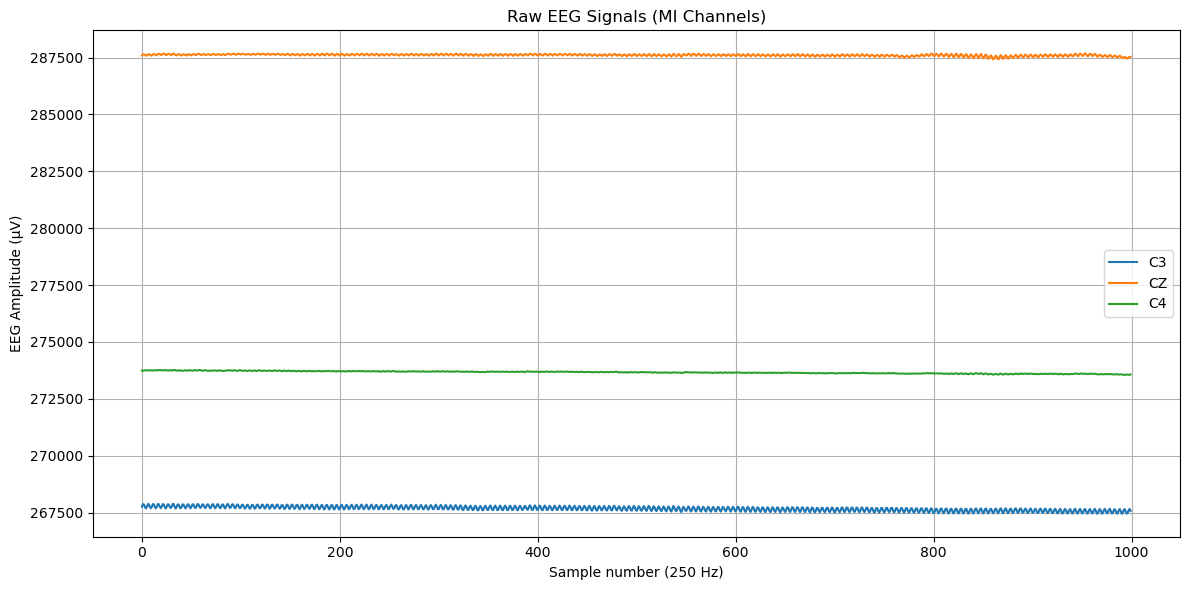

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define file path
file_path = r"C:\Users\zezom\PycharmProjects\HorusEye\Data\Raw\SSVEP\train\S2\2\EEGdata.csv"  # Use raw string or double backslashes

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load data
eeg_df = pd.read_csv(file_path)

# Display data structure
print("First 5 rows of the data:")
print(eeg_df.head())
print("\nColumns in data:", eeg_df.columns.tolist())

# EEG channels for MI (change these based on your dataset)
mi_channels = ['C3', 'CZ', 'C4']

# Check if channels exist in data
for ch in mi_channels:
    if ch not in eeg_df.columns:
        raise ValueError(f"Channel {ch} not found in the data columns!")

# Plot raw EEG signal
plt.figure(figsize=(12, 6))
for ch in mi_channels:
    plt.plot(eeg_df[ch][:1000], label=ch)  # Plot first 4 seconds (1000 samples at 250 Hz)

plt.xlabel('Sample number (250 Hz)')
plt.ylabel('EEG Amplitude (µV)')
plt.title('Raw EEG Signals (MI Channels)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


First 5 rows:
           Time            FZ            C3            CZ            C4  \
0  1.125424e+06  283939.93750  267756.84375  287589.09375  273740.40625   
1  1.125424e+06  283896.75000  267865.90625  287632.46875  273734.31250   
2  1.125424e+06  283904.09375  267850.43750  287637.37500  273735.84375   
3  1.125424e+06  283962.21875  267743.06250  287620.75000  273749.96875   
4  1.125424e+06  283984.28125  267679.21875  287582.37500  273748.18750   

             PZ            PO7             OZ            PO8      AccX  \
0  265207.12500  244613.562500  244947.421875  248275.046875 -0.020752   
1  265304.03125  244755.906250  245063.640625  248751.765625 -0.021240   
2  265321.31250  244758.500000  245099.312500  248876.500000 -0.018311   
3  265257.00000  244635.468750  245009.906250  248540.140625 -0.017822   
4  265177.81250  244536.859375  244894.484375  248149.171875 -0.019043   

       AccY      AccZ     Gyro1      Gyro2     Gyro3    Battery   Counter  \
0  0.999268 -

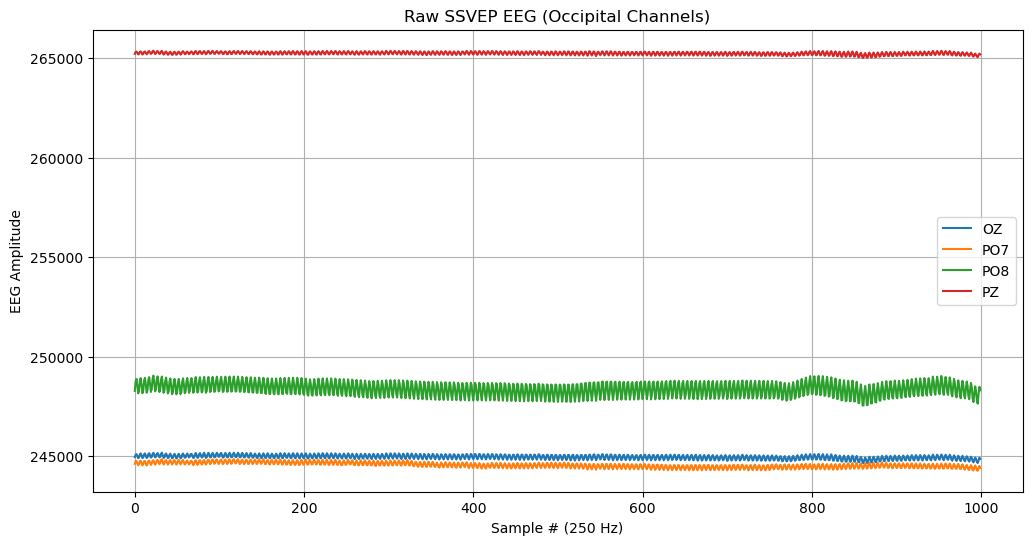

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- SETTINGS ---
file_path = r"C:\Users\zezom\PycharmProjects\HorusEye\Data\Raw\SSVEP\train\S2\2\EEGdata.csv"
ssvep_channels = ['OZ', 'PO7', 'PO8', 'PZ']  # You can add/remove channels if needed

# --- Load data ---
eeg_df = pd.read_csv(file_path)
print("First 5 rows:")
print(eeg_df.head())
print("Columns in data:", eeg_df.columns.tolist())

# --- Check channels exist ---
for ch in ssvep_channels:
    if ch not in eeg_df.columns:
        raise ValueError(f"Channel {ch} not found!")

# --- Plot raw SSVEP channels ---
plt.figure(figsize=(12, 6))
for ch in ssvep_channels:
    plt.plot(eeg_df[ch][:1000], label=ch)  # First 4s if 250 Hz
plt.xlabel('Sample # (250 Hz)')
plt.ylabel('EEG Amplitude')
plt.title('Raw SSVEP EEG (Occipital Channels)')
plt.legend()
plt.grid(True)
plt.show()


In [18]:

                                   #LaST Version Give me Best Data
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import os
import glob

# -------- CONFIG --------
raw_dir = r"C:\Users\zezom\PycharmProjects\HorusEye\Data\Raw\SSVEP\validation"
save_dir = r"C:\Users\zezom\PycharmProjects\HorusEye\Data\Validate\SSVEP"
dl_ready_dir = os.path.join(save_dir, "DL_ready")
os.makedirs(save_dir, exist_ok=True)
os.makedirs(dl_ready_dir, exist_ok=True)

samples_per_trial = 1750  # SSVEP: 7s * 250Hz
raw_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']  # ALL EEG CHANNELS
dl_channels = [ch + "_ref" for ch in raw_channels]
fs = 250
lowcut = 5
highcut = 45
order = 4
artifact_thresh = 200  # Increased threshold to prevent aggressive rejection

def load_eeg_csv(file_path, channels):
    df = pd.read_csv(file_path)
    missing = [ch for ch in channels if ch not in df.columns]
    if missing:
        raise ValueError(f"Channels {missing} not found in data columns!")
    return df[channels]

def rereference_average(df):
    avg = df.mean(axis=1)
    reref = df.subtract(avg, axis=0)
    reref.columns = [f"{col}_ref" for col in df.columns]
    return reref

def bandpass_filter(data, lowcut=5, highcut=45, fs=250, order=4):
    b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    return filtfilt(b, a, data, axis=0)

def filter_dataframe(df, fs=250, lowcut=5, highcut=45, order=4):
    arr = df.values
    arr_filt = bandpass_filter(arr, lowcut, highcut, fs, order)
    return pd.DataFrame(arr_filt, columns=df.columns)

def artifact_reject(df, threshold=200):
    mask = (np.abs(df) > threshold).any(axis=1)
    return df[~mask].reset_index(drop=True)

def preprocess_eeg_file(
        file_path,
        channels=raw_channels,
        fs=250,
        lowcut=5,
        highcut=45,
        threshold=200
):
    raw = load_eeg_csv(file_path, channels)
    reref = rereference_average(raw)
    filt = filter_dataframe(reref, fs, lowcut, highcut)
    clean = artifact_reject(filt, threshold)
    return clean

def save_preprocessed(clean_df, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    clean_df.to_csv(save_path, index=False)
    print(f"Preprocessed EEG saved to: {save_path}")

def make_dl_ready(
        csv_path,
        save_dir,
        channels=dl_channels,
        samples_per_trial=1750,
        subject="S1",
        session=1
):
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(csv_path)

    for ch in channels:
        if ch not in df.columns:
            raise ValueError(f"Channel {ch} not found in preprocessed CSV!")

    total_samples = df.shape[0]
    n_trials = total_samples // samples_per_trial
    usable_samples = n_trials * samples_per_trial

    df_epochs = df.iloc[:usable_samples][channels]
    epochs = df_epochs.to_numpy().reshape(n_trials, samples_per_trial, len(channels)).transpose(0, 2, 1)

    np.save(os.path.join(save_dir, f"{subject}_{session}_DLready.npy"), epochs)

    trial_index = pd.DataFrame({
        "subject": [subject] * n_trials,
        "session": [session] * n_trials,
        "trial": np.arange(1, n_trials + 1)
    })
    trial_index.to_csv(os.path.join(save_dir, f"{subject}_{session}_index.csv"), index=False)

    print(f"Saved DL-ready data and trial index for {subject} session {session}")

# -------- BATCH PROCESSING --------
all_files = glob.glob(os.path.join(raw_dir, "S*", "*", "EEGdata.csv"))

for file_path in all_files:
    parts = file_path.split(os.sep)
    subject, session = parts[-3], parts[-2]

    clean = preprocess_eeg_file(file_path, raw_channels, fs, lowcut, highcut, artifact_thresh)

    basename = f"{subject}_{session}_EEGdata_preprocessed.csv"
    save_path = os.path.join(save_dir, basename)
    save_preprocessed(clean, save_path)

    make_dl_ready(save_path, dl_ready_dir, dl_channels, samples_per_trial, subject, session)

print("Batch SSVEP preprocessing complete!")


Preprocessed EEG saved to: C:\Users\zezom\PycharmProjects\HorusEye\Data\Validate\SSVEP\S31_1_EEGdata_preprocessed.csv
Saved DL-ready data and trial index for S31 session 1
Preprocessed EEG saved to: C:\Users\zezom\PycharmProjects\HorusEye\Data\Validate\SSVEP\S32_1_EEGdata_preprocessed.csv
Saved DL-ready data and trial index for S32 session 1
Preprocessed EEG saved to: C:\Users\zezom\PycharmProjects\HorusEye\Data\Validate\SSVEP\S33_1_EEGdata_preprocessed.csv
Saved DL-ready data and trial index for S33 session 1
Preprocessed EEG saved to: C:\Users\zezom\PycharmProjects\HorusEye\Data\Validate\SSVEP\S34_1_EEGdata_preprocessed.csv
Saved DL-ready data and trial index for S34 session 1
Preprocessed EEG saved to: C:\Users\zezom\PycharmProjects\HorusEye\Data\Validate\SSVEP\S35_1_EEGdata_preprocessed.csv
Saved DL-ready data and trial index for S35 session 1
Batch SSVEP preprocessing complete!


In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

# --- SETTINGS (EDIT THESE) ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
dl_ready_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP", "DL_ready")
labels_path = os.path.join(base_dir, "train.csv")  # EDIT: Use your SSVEP label file

# --- Load SSVEP labels ---
labels_df = pd.read_csv(labels_path)

X = []
y = []
missing = []

for i, row in labels_df.iterrows():
    subject = row['subject_id']
    session = row['trial_session']
    trial_num = int(row['trial'])    # 1-based
    label = row['label']
    # Path to preprocessed SSVEP file
    npy_path = os.path.join(dl_ready_dir, f"{subject}_{session}_EEGdata_preprocessed_DLready.npy")
    if not os.path.exists(npy_path):
        missing.append(npy_path)
        continue
    epochs = np.load(npy_path)  # (n_trials, n_channels, samples)
    # Safety check:
    if trial_num-1 >= epochs.shape[0]:
        print(f"Trial number {trial_num} out of range for file: {npy_path}")
        continue
    # Append correct trial (trial number - 1 for zero-indexing)
    X.append(epochs[trial_num-1])
    y.append(label)

X = np.stack(X)
y_enc = LabelEncoder().fit_transform(y)

print("Loaded SSVEP data shape:", X.shape)
print("Encoded SSVEP labels shape:", y_enc.shape)
if missing:
    print(f"Missing {len(missing)} files, e.g.:", missing[:3])


ValueError: need at least one array to stack

# Last Version

In [11]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from sklearn.preprocessing import LabelEncoder
import glob

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
raw_dir = os.path.join(base_dir, "Data", "Raw", "SSVEP", "train")
proc_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP")
os.makedirs(proc_dir, exist_ok=True)

labels_path = os.path.join(base_dir, "train.csv")
samples_per_trial = 1750
sampling_rate = 250
psd_band = (5, 45)

# --- Load Labels ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
label_map = {
    (str(row['subject_id']).strip(), str(row['trial_session']).strip(), int(row['trial'])): str(row['label']).strip()
    for _, row in labels_df.iterrows()
}

X = []
y = []
skipped = []

all_files = glob.glob(os.path.join(raw_dir, "S*", "*", "EEGdata.csv"))
print("Found raw files:", all_files)

for raw_csv in all_files:
    parts = raw_csv.replace("\\", "/").split("/")
    subject = parts[-3]
    session = parts[-2]
    df = pd.read_csv(raw_csv)
    channels = [c for c in df.columns if c not in ['timestamp', 'marker', 'label']]
    n_samples = df.shape[0]
    n_trials = n_samples // samples_per_trial
    usable_samples = n_trials * samples_per_trial

    print(f"[INFO] {subject}_{session} | Trials: {n_trials} | Channels: {len(channels)}")

    for i in range(n_trials):
        trial_num = i + 1  # 1-based
        idx_key = (subject, session, trial_num)
        if idx_key not in label_map:
            print(f"[WARN] Label not found for {idx_key}, skipping trial.")
            skipped.append(idx_key)
            continue

        start_idx = i * samples_per_trial
        end_idx = (i + 1) * samples_per_trial
        trial_data = df[channels].iloc[start_idx:end_idx].values
        if trial_data.shape[0] != samples_per_trial:
            print(f"[WARN] Skipping incomplete trial {trial_num} in {subject}_{session}")
            skipped.append(idx_key)
            continue

        # PSD Features
        psd_features = []
        for ch in range(trial_data.shape[1]):
            freqs, psd = welch(trial_data[:, ch], fs=sampling_rate, nperseg=256)
            band = (freqs >= psd_band[0]) & (freqs <= psd_band[1])
            psd_features.extend(psd[band])
        X.append(psd_features)
        y.append(label_map[idx_key])

X = np.array(X)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

print("Final feature array shape:", X.shape)
print("Encoded labels shape:", y_enc.shape)
if skipped:
    print(f"Skipped {len(skipped)} trials, e.g.:", skipped[:5])
else:
    print("All trials loaded successfully.")

# --- Save to Data/Processed/SSVEP ---
np.save(os.path.join(proc_dir, "ssvep_psd_features.npy"), X)
np.save(os.path.join(proc_dir, "ssvep_labels.npy"), y_enc)
with open(os.path.join(proc_dir, "ssvep_label_encoder.pkl"), "wb") as f:
    import pickle
    pickle.dump(label_encoder, f)
print(f"[SAVED] PSD features and labels to {proc_dir}")


Found raw files: ['C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\2\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\3\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\4\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\5\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\6\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\7\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\8\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S10\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S10\\2\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSV

In [12]:
import os
import pandas as pd
import glob

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
raw_dir = os.path.join(base_dir, "Data", "Raw", "SSVEP", "test")
save_dir = os.path.join(base_dir, "Data", "Test", "SSVEP")
os.makedirs(save_dir, exist_ok=True)

all_files = glob.glob(os.path.join(raw_dir, "S*", "*", "EEGdata.csv"))
print("Found raw files:", all_files)

for raw_csv in all_files:
    parts = raw_csv.replace("\\", "/").split("/")
    subject = parts[-3]   # e.g. 'S1'
    session = parts[-2]   # e.g. '1'
    df = pd.read_csv(raw_csv)

    # Remove columns that aren't channels (keep only EEG data)
    channel_cols = [c for c in df.columns if c not in ['timestamp', 'marker', 'label']]
    preprocessed = df[channel_cols]

    # Save as processed CSV
    out_name = f"{subject}_{session}_EEGdata_preprocessed.csv"
    out_path = os.path.join(save_dir, out_name)
    preprocessed.to_csv(out_path, index=False)
    print(f"[SAVED] {out_path} ({preprocessed.shape[0]} samples, {preprocessed.shape[1]} channels)")

print("All SSVEP files preprocessed and saved as CSV.")


Found raw files: ['C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\test\\S36\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\test\\S37\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\test\\S38\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\test\\S39\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\test\\S40\\1\\EEGdata.csv']
[SAVED] C:\Users\zezom\PycharmProjects\HorusEye\Data\Test\SSVEP\S36_1_EEGdata_preprocessed.csv (17500 samples, 18 channels)
[SAVED] C:\Users\zezom\PycharmProjects\HorusEye\Data\Test\SSVEP\S37_1_EEGdata_preprocessed.csv (17500 samples, 18 channels)
[SAVED] C:\Users\zezom\PycharmProjects\HorusEye\Data\Test\SSVEP\S38_1_EEGdata_preprocessed.csv (17500 samples, 18 channels)
[SAVED] C:\Users\zezom\PycharmProjects\HorusEye\Data\Test\SSVEP\S39_1_EEGdata_preprocessed.csv (17500 samples, 18 channels)
[SAVED] C:\Users\zezom\Pyc

# Processing For deep Learning

In [13]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from sklearn.preprocessing import LabelEncoder
import glob
import pickle

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
raw_dir = os.path.join(base_dir, "Data", "Raw", "SSVEP", "train")
save_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP")
os.makedirs(save_dir, exist_ok=True)

labels_path = os.path.join(base_dir, "train.csv")
samples_per_trial = 1750
sampling_rate = 250
psd_band = (5, 45)

# --- Load Labels Map ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
label_map = {
    (str(row['subject_id']).strip(), str(row['trial_session']).strip(), int(row['trial'])): str(row['label']).strip()
    for _, row in labels_df.iterrows()
}

# --- Preprocessing Loop ---
all_files = glob.glob(os.path.join(raw_dir, "S*", "*", "EEGdata.csv"))
print("[INFO] Found raw files:", all_files)

X = []
y = []
meta = []
skipped = []

for raw_csv in all_files:
    parts = raw_csv.replace("\\", "/").split("/")
    subject = parts[-3]   # e.g. 'S1'
    session = parts[-2]   # e.g. '1'
    df = pd.read_csv(raw_csv)

    # Remove non-EEG columns
    channel_cols = [c for c in df.columns if c not in ['timestamp', 'marker', 'label']]
    preprocessed = df[channel_cols]

    n_samples = preprocessed.shape[0]
    n_trials = n_samples // samples_per_trial
    usable_samples = n_trials * samples_per_trial

    if n_trials == 0:
        print(f"[SKIP] No complete trials for {subject}_{session}")
        continue

    print(f"[INFO] {subject}_{session}: {n_trials} trials, {len(channel_cols)} channels")

    # Save processed flat CSV for inspection
    out_name = f"{subject}_{session}_EEGdata_preprocessed.csv"
    out_path = os.path.join(save_dir, out_name)
    preprocessed.to_csv(out_path, index=False)

    # Segment into trials and extract PSD
    for i in range(n_trials):
        trial_num = i + 1  # 1-based indexing
        idx_key = (subject, session, trial_num)
        if idx_key not in label_map:
            print(f"[WARN] Label not found for {idx_key}, skipping.")
            skipped.append(idx_key)
            continue

        start_idx = i * samples_per_trial
        end_idx = (i + 1) * samples_per_trial
        trial_data = preprocessed.iloc[start_idx:end_idx].values

        if trial_data.shape[0] != samples_per_trial:
            print(f"[SKIP] Incomplete trial {trial_num} in {subject}_{session}")
            skipped.append(idx_key)
            continue

        # --- PSD Features ---
        psd_features = []
        for ch in range(trial_data.shape[1]):
            freqs, psd = welch(trial_data[:, ch], fs=sampling_rate, nperseg=256)
            band_mask = (freqs >= psd_band[0]) & (freqs <= psd_band[1])
            psd_features.extend(psd[band_mask])
        X.append(psd_features)
        y.append(label_map[idx_key])
        meta.append({'subject': subject, 'session': session, 'trial': trial_num})

X = np.array(X)
y = np.array(y)
print("[INFO] Final feature array shape:", X.shape)
print("[INFO] Number of labels:", len(y))

# --- Encode Labels ---
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# --- Save Features & Labels ---
np.save(os.path.join(save_dir, "ssvep_psd_features.npy"), X)
np.save(os.path.join(save_dir, "ssvep_labels.npy"), y_enc)
with open(os.path.join(save_dir, "ssvep_label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)
pd.DataFrame(meta).to_csv(os.path.join(save_dir, "ssvep_meta.csv"), index=False)
print(f"[SAVED] PSD features, labels, and meta-data to {save_dir}")

if skipped:
    print(f"[WARN] Skipped {len(skipped)} trials. Example:", skipped[:5])
else:
    print("[INFO] All trials loaded successfully.")


[INFO] Found raw files: ['C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\2\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\3\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\4\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\5\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\6\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\7\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S1\\8\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S10\\1\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\Raw\\SSVEP\\train\\S10\\2\\EEGdata.csv', 'C:\\Users\\zezom\\PycharmProjects\\HorusEye\\Data\\R